## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

/bin/sh: line 0: cd: datasets: No such file or directory
--2016-06-25 18:31:24--  https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
Resolving 2016.mlhep.yandex.net... 213.180.193.208, 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net|213.180.193.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932820 (911K) [application/octet-stream]
Saving to: “public_train_10000.root”

100%[======================================>] 932,820     3.03M/s   in 0.3s    

2016-06-25 18:31:25 (3.03 MB/s) - “public_train_10000.root” saved [932820/932820]



In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [4]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

/bin/sh: line 0: cd: datasets: No such file or directory
--2016-06-25 18:31:29--  https://2016.mlhep.yandex.net/data/higgs/public_test.root
Resolving 2016.mlhep.yandex.net... 213.180.193.208, 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net|213.180.193.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91931408 (88M) [application/octet-stream]
Saving to: “public_test.root”

100%[======================================>] 91,931,408  32.5M/s   in 2.7s    

2016-06-25 18:31:32 (32.5 MB/s) - “public_test.root” saved [91931408/91931408]



### Read the smallest part of training file and test file

In [23]:
import pandas as pd
df = pd.DataFrame.from_csv("/homeappl/home/austyuzh/data/train_small.csv",)
n_features = df.shape[1]-1

jet_pt   = ['jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']
jet_eta  = ['jet1_eta', 'jet2_eta', 'jet3_eta', 'jet4_eta']
jet_phi  = ['jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi']
jet_btag = ['jet1_btag', 'jet2_btag', 'jet3_btag', 'jet4_btag']

allvars = [jet_pt, jet_eta, jet_phi, jet_btag]

dfa = np.argsort(df[jet_pt])                             #argsort indices
dfs = df.copy()                                          #sorted jets dataframe
indexer = np.arange(dfs[jet_pt].shape[0])[:,np.newaxis]  #index that help us sort the matrix
                                                         #column vector of range 0->n_entries
for v in allvars:
    dfs[v] = dfs[v].values[indexer, dfa]
    
df = dfs

In [24]:
data = df
data.head()

,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
event_id,,,,,,,,,,,,,,,,,,,,,
1000001,1.0,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1000002,1.0,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,0.000000,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559
1000003,1.0,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,0.000000,...,-0.211263,1.326902,0.000000,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838
1000004,0.0,45.950066,1.613817,0.964722,39.302082,-0.075989,15.260404,2.409047,-0.850500,0.000000,...,0.465748,2.287783,2.000016,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831
1000005,0.0,44.409187,-0.228907,-1.837974,49.886654,0.156533,29.664640,-0.031725,-1.192486,0.000000,...,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905


### Define training features

Exclude `event_id`, `target` from the features set

In [25]:
features = list(set(data.columns) - {'event_id', 'target'})
features

['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Prepare high-level features for training

In [26]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

### Plot histograms for each high-level feature

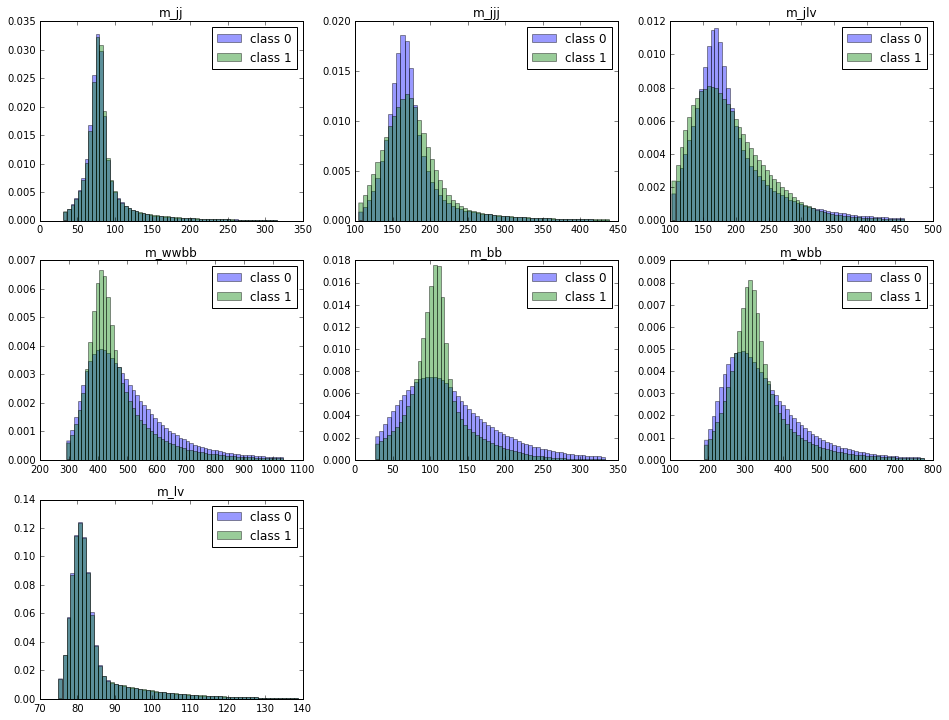

In [27]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [28]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.66)

### Simple knn from `sklearn` training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=2000)
rfc.fit(training_data[features], training_data.target)

#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(training_data[features], training_data.target)

In [20]:
# predict validation sample (probability for each event)
#proba_knn = knn.predict_proba(validation_data[features])
proba_rfc = rfc.predict_proba(validation_data[features])

In [ ]:
df_features = pandas.DataFrame()
df_features[0] = rfc.feature_importances_
df_features.index = features

df_features.plot(kind='barh')

In [21]:
# take probability to be 1 class to compute ROC AUC
print(training_data.shape)
print(roc_auc_score(validation_data.target, proba_rfc[:, 1]))
print(roc_auc_score(validation_data.target, proba_knn[:, 1]))

array([[ 0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ],
       [ 0.83333333,  0.16666667],
       ..., 
       [ 0.16666667,  0.83333333],
       [ 0.5       ,  0.5       ],
       [ 0.33333333,  0.66666667]])

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

In [22]:
from matplotlib import offsetbox
import numpy as np
def plot_embedding(X,y,ax=None,show_images=False,min_dist=1e-2):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 10})

0.72604276203090268

In [ ]:
from sklearn.decomposition import PCA
xpca = PCA(n_components=2).fit_transform(training_data[features])
#print(training_data.target)
print(xpca)
plot_embedding(xpca,training_data.target.values)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
xlda = lda.fit_transform(training_data[features], training_data.target)
print(pandas.DataFrame(xlda))
#plot_embedding(xlda,training_data.target.values)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,verbose=2,perplexity=50)
xtsne = tsne.fit_transform(training_data[features])
plot_embedding(xtsne,training_data.target.values)

## Prepare submission to kaggle

In [17]:
# predict test sample
kaggle_proba = knn.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

In [18]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/Users/antares/Yandex.Disk.localized/projects/MLHEP/mlhep2016/higgs_kaggle/datasets/baseline.csv